In [2]:
"""Domanda 13 (Deblur). Discutere la ricostruzione di un’immagine corrotta da blur e rumore,
mostrando la soluzione naive, ottenuta risolvendo il problema dei minimi quadrati e la 
soluzione ottenuta con il metodo di regolarizzazione di Tikhonov. Mostrare inoltre le 
immagini ricostruite e i grafici dei parametri PSNR e MSE al variare del numero di 
iterazioni. Infine discutere i risultati al variare del parametro di regolarizzazione λ."""
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, metrics
from scipy import signal
from numpy import fft
from utils import psf_fft, A, AT, gaussian_kernel 
from scipy.optimize import minimize
from skimage.io import imread

Grafo filtro blur:



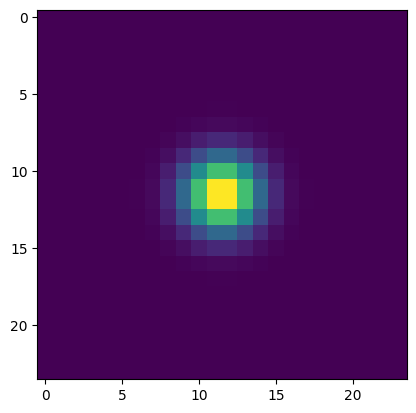

Applicazione filtro blur (openCV):



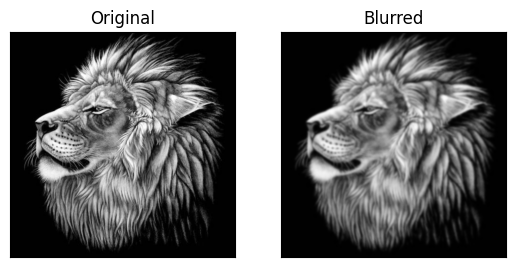

Blur FFT:



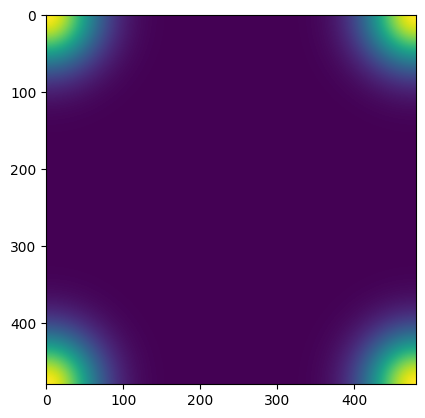

Rumore generato: [[ 0.00993428 -0.00276529  0.01295377 ...  0.006225    0.06157762
   0.0223915 ]
 [-0.00255835 -0.01911081 -0.03212893 ...  0.00913506  0.01139535
   0.00895417]
 [ 0.01285446  0.02658305  0.00393042 ...  0.03214691  0.0098195
   0.01469756]
 ...
 [ 0.01056878  0.00089712 -0.01632797 ...  0.01556293  0.00545553
  -0.01837128]
 [ 0.01808934  0.01093191 -0.00228084 ... -0.0082149   0.01420958
   0.01913496]
 [ 0.02336435 -0.01883178 -0.03671632 ...  0.00914589 -0.02912007
  -0.0331098 ]]

PSNR: 23.371973108785845
 MSE: 0.004600475149670755

Confronto immagine originale/corrotta:



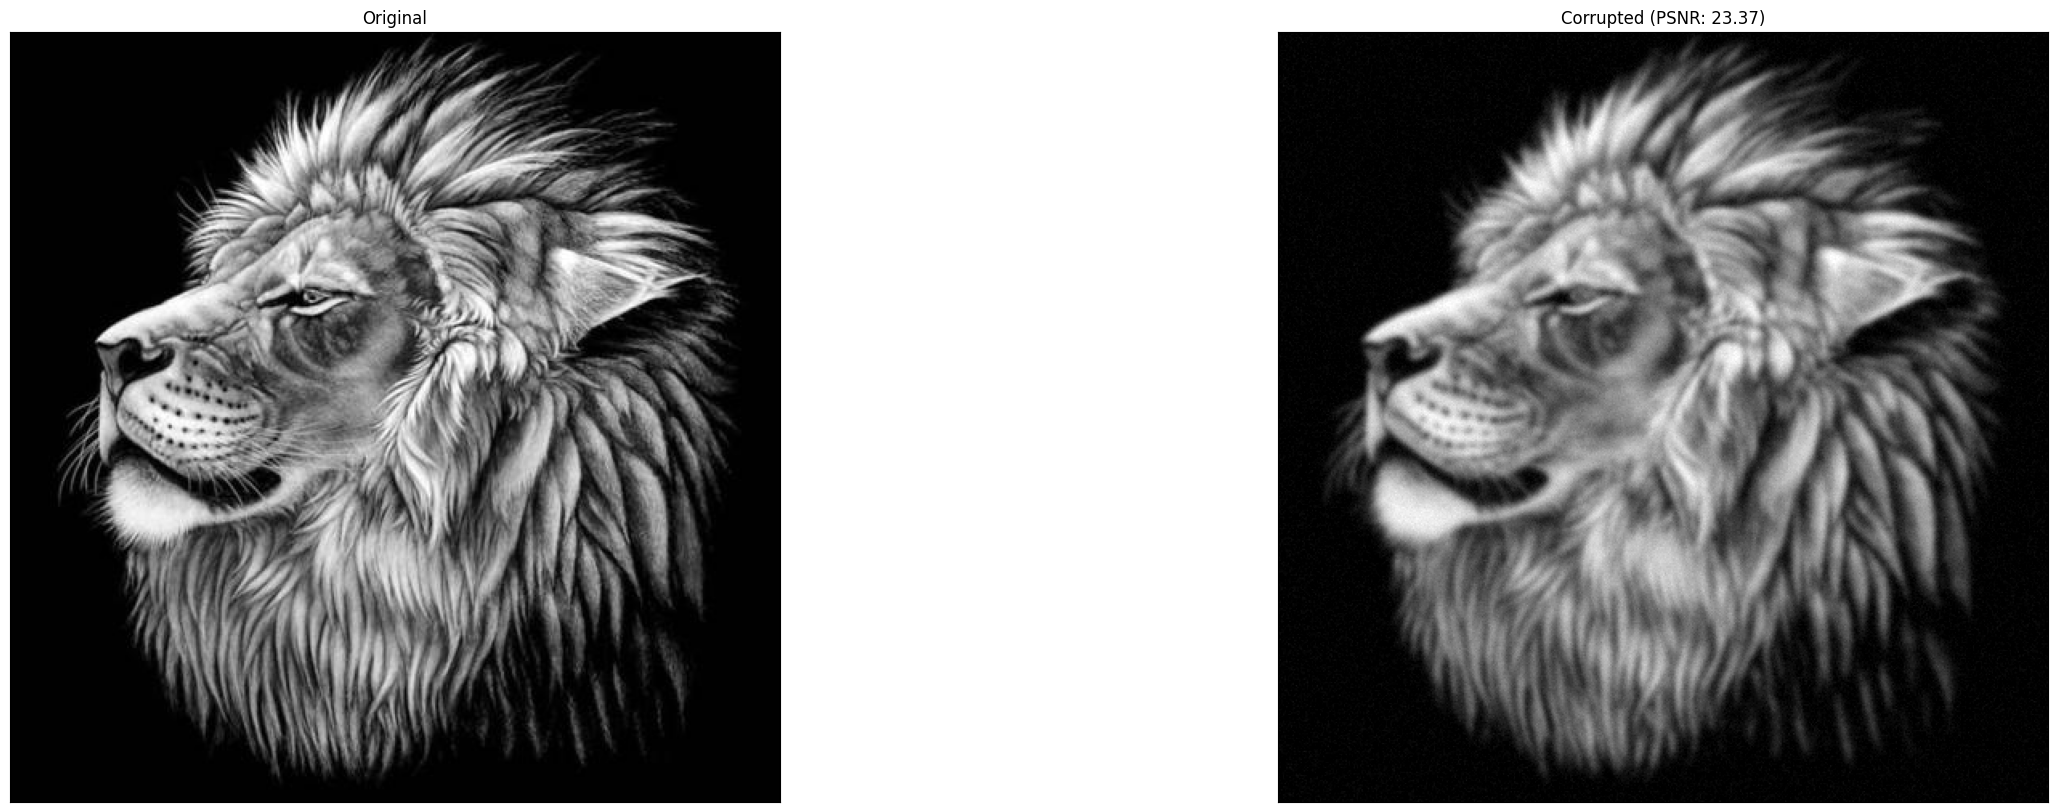

Risultato minimizzazione: [[ 0.01445744 -0.01948003 -0.0310468  ...  0.02684049  0.03274493
  -0.0097884 ]
 [-0.00259711 -0.0697081  -0.09392864 ...  0.09255017  0.07613387
   0.04528276]
 [ 0.02991621  0.0080999  -0.0656213  ...  0.08368603  0.08036044
   0.06095147]
 ...
 [ 0.14734662  0.04174647 -0.13086737 ...  0.04910945 -0.07792232
  -0.02208978]
 [ 0.18739982  0.1152765  -0.07551336 ... -0.03237279 -0.05668792
   0.0379873 ]
 [ 0.10701457  0.04516451 -0.08641052 ... -0.03354362 -0.11417819
  -0.06984909]]

PSNR immagine corrotta rispetto oginale: [23.37197311 23.37197311 23.37197311 23.37197311 23.37197311 23.37197311
 23.37197311 23.37197311 23.37197311 23.37197311 23.37197311 23.37197311
 23.37197311 23.37197311 23.37197311 23.37197311 23.37197311 23.37197311
 23.37197311 23.37197311 23.37197311 23.37197311 23.37197311 23.37197311
 23.37197311 23.37197311]

MSE immagine corrotta rispetto oginale: [0.00460048 0.00460048 0.00460048 0.00460048 0.00460048 0.00460048
 0.00460048 0.

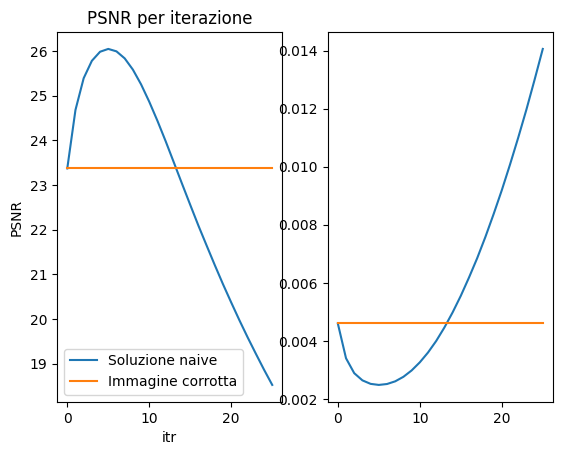

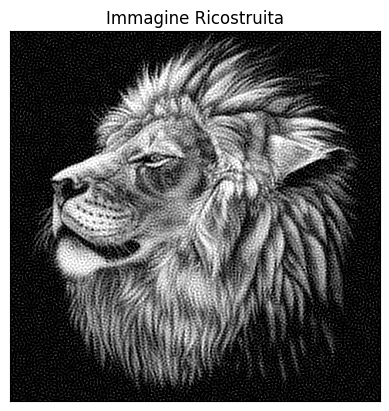

Variazione lambda in 0.01-0.006:

PSNR: 26.01 (λ = 0.01)
MSE: 0.0025 (λ = 0.01)
PSNR: 26.37 (λ = 0.03)
MSE: 0.0023 (λ = 0.03)
PSNR: 26.08 (λ = 0.04)
MSE: 0.0025 (λ = 0.04)
PSNR: 25.38 (λ = 0.06)
MSE: 0.0029 (λ = 0.06)


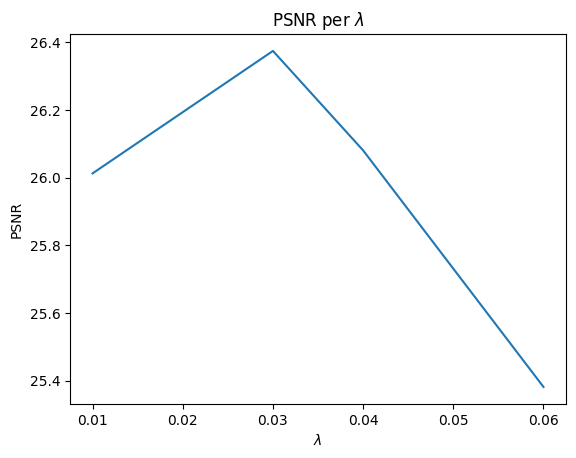

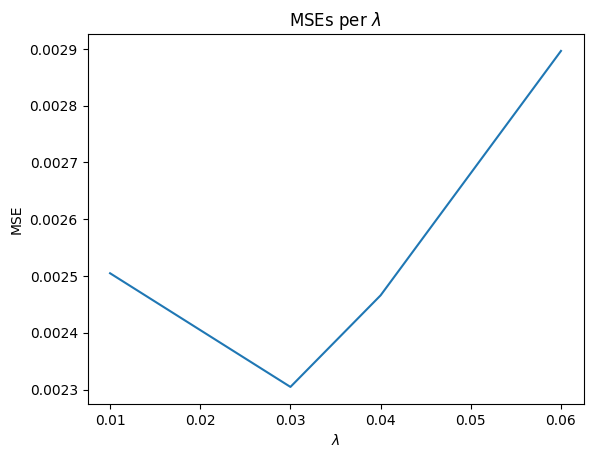

Immagini ricostruite a confronto:



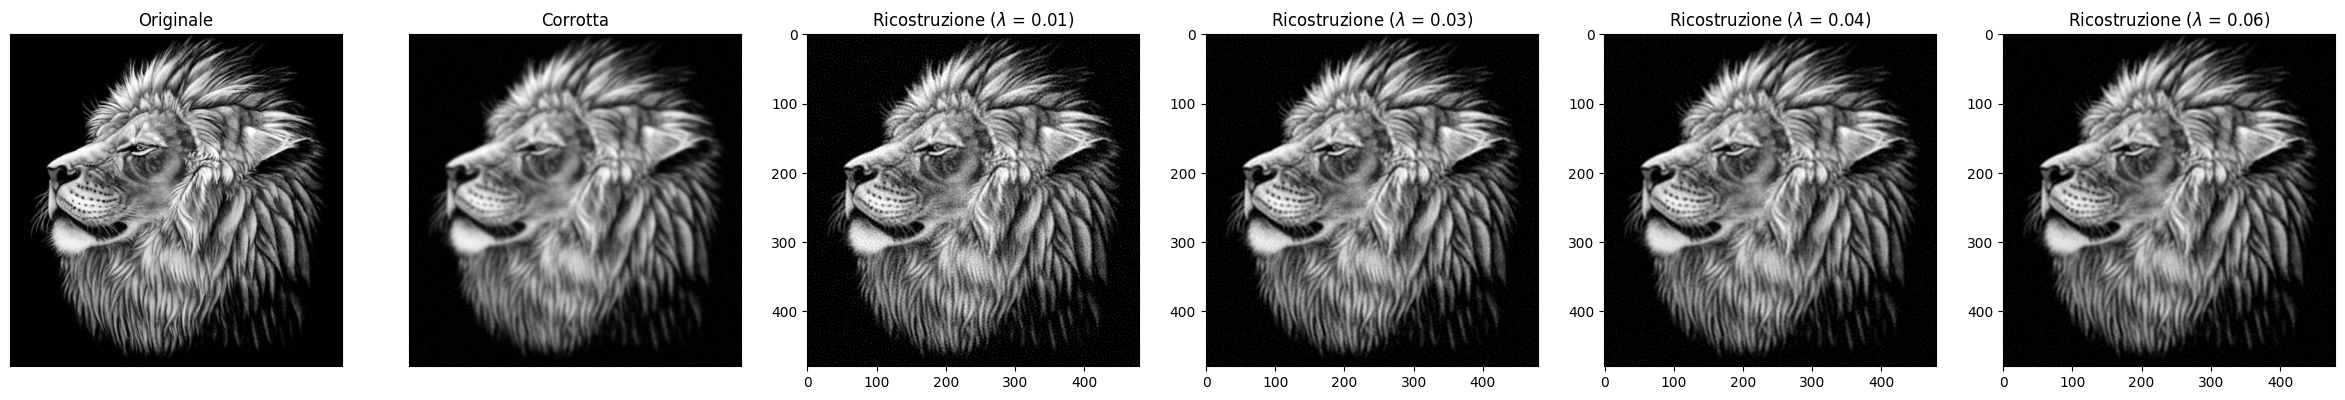

In [3]:
X = imread('image2.png').astype(np.float64)/255 
m, n = X.shape

print('Grafo filtro blur:\n')
k = gaussian_kernel(24,3)
plt.imshow(k)
plt.show()

print('Applicazione filtro blur (openCV):\n')
X_blurred = cv.filter2D(X,-1,k)
plt.subplot(121).imshow(X, cmap='gray', vmin=0, vmax=1)
plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122).imshow(X_blurred, cmap='gray', vmin=0, vmax=1)
plt.title('Blurred')
plt.xticks([]), plt.yticks([])
plt.show()

print('Blur FFT:\n')
K = psf_fft(k,24,X.shape)
plt.imshow(np.abs(K))
plt.show()

X_blurred = A(X,K)

sigma = 0.02
np.random.seed(42)
noise = np.random.normal(size=X.shape) * sigma
print(f'Rumore generato: {noise}\n')

y = X_blurred + noise
PSNR = metrics.peak_signal_noise_ratio(X,y) 
mse = metrics.mean_squared_error(X,y) 
ATy = AT(y, K)

print(f'PSNR: {PSNR}\n MSE: {mse}\n')

print('Confronto immagine originale/corrotta:\n')
plt.figure(figsize=(30, 10))
plt.subplot(121).imshow(X, cmap='gray', vmin=0, vmax=1)
plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122).imshow(y, cmap='gray', vmin=0, vmax=1)
plt.title(f'Corrupted (PSNR: {PSNR:.2f})')
plt.xticks([]), plt.yticks([])
plt.show()

def f(x):
    x = x.reshape((m, n))
    Ax = A(x, K)
    return 0.5 * np.sum(np.square(Ax - y))

def df(x):
    x = x.reshape((m, n))
    ATAx = AT(A(x,K),K)
    d = ATAx - ATy
    return d.reshape(m * n)

x0 = y.reshape(m*n)
max_iter = 25
res = minimize(f, x0, method='CG', jac=df, options={'maxiter':max_iter, 'return_all':True})

PSNR = np.zeros(max_iter + 1)
MSE = np.zeros(max_iter + 1)
for k, x_k in enumerate(res.allvecs):
    PSNR[k] = metrics.peak_signal_noise_ratio(X, x_k.reshape(X.shape))
    MSE[k] = metrics.mean_squared_error(X, x_k.reshape(X.shape))

X_res = res.x.reshape((m, n))
print(f'Risultato minimizzazione: {X_res}\n')

starting_PSNR = np.full(PSNR.shape[0], metrics.peak_signal_noise_ratio(X, y))
starting_MSE = np.full(MSE.shape[0], metrics.mean_squared_error(X, y))
print(f'PSNR immagine corrotta rispetto oginale: {starting_PSNR}\n')
print(f'MSE immagine corrotta rispetto oginale: {starting_MSE}\n')

print('Risultati soluzione Naive:\n')
ax2 = plt.subplot(1, 2, 1)
ax2.plot(PSNR, label="Soluzione naive")
ax2.plot(starting_PSNR, label="Immagine corrotta")
plt.legend()
plt.title('PSNR per iterazione')
plt.ylabel("PSNR")
plt.xlabel('itr')
ax3 = plt.subplot(1, 2,2)
ax3.plot(MSE, label="Soluzione naive")
ax3.plot(starting_MSE, label="Immagine corrotta")
plt.show()

plt.imshow(X_res, cmap='gray', vmin=0, vmax=1)
plt.title('Immagine Ricostruita')
plt.xticks([]), plt.yticks([])
plt.show()

def f(x, L):
    nsq = np.sum(np.square(x))
    x  = x.reshape((m, n))
    Ax = A(x, K)
    return 0.5 * np.sum(np.square(Ax - y)) + 0.5 * L * nsq

def df(x, L):
    Lx = L * x
    x = x.reshape(m, n)
    ATAx = AT(A(x,K),K)
    d = ATAx - ATy
    return d.reshape(m * n) + Lx

print('Variazione lambda in 0.01-0.006:\n')
x0 = y.reshape(m*n)
lambdas = [0.01,0.03,0.04, 0.06]
PSNRs = []
MSEs = []
images = []

for i, L in enumerate(lambdas):

    max_iter = 50
    res = minimize(f, x0, (L), method='CG', jac=df, options={'maxiter':max_iter})

    X_curr = res.x.reshape(X.shape)
    images.append(X_curr)

    PSNR = metrics.peak_signal_noise_ratio(X, X_curr)
    PSNRs.append(PSNR)
    print(f'PSNR: {PSNR:.2f} (\u03BB = {L:.2f})')
    MSE = metrics.mean_squared_error(X, X_curr)
    MSEs.append(MSE)
    print(f'MSE: {MSE:.4f} (\u03BB = {L:.2f})')

plt.plot(lambdas,PSNRs)
plt.title('PSNR per $\lambda$')
plt.ylabel("PSNR")
plt.xlabel('$\lambda$')
plt.show()
plt.plot(lambdas,MSEs)
plt.title('MSEs per $\lambda$')
plt.ylabel("MSE")
plt.xlabel('$\lambda$')
plt.show()
plt.figure(figsize=(30, 10))

plt.subplot(1, len(lambdas) + 2, 1).imshow(X, cmap='gray', vmin=0, vmax=1)
plt.title("Originale")
plt.xticks([]), plt.yticks([])
plt.subplot(1, len(lambdas) + 2, 2).imshow(y, cmap='gray', vmin=0, vmax=1)
plt.title("Corrotta")
plt.xticks([]), plt.yticks([])

print('Immagini ricostruite a confronto:\n')
for i, L in enumerate(lambdas):
  plt.subplot(1, len(lambdas) + 2, i + 3).imshow(images[i], cmap='gray', vmin=0, vmax=1)
  plt.title(f"Ricostruzione ($\lambda$ = {L:.2f})")
plt.show()